# Predictive Analysis of Epilepsy based on features extracted from MRI images

The zscored freesurfer features measuring thickness, volume and surface of the brain areas are used to predict the epilepsy status of the patients.


In [1]:
#import libraries and modules
import pandas as pd
import numpy as np

In [35]:
def load_aparc_data(file_path):
    """
    Liest die Daten aus einer aparc Datei ein und bereitet sie auf.
    
    Args:
        file_path (str): Pfad zur aparc Datei
        
    Returns:
        pd.DataFrame: Aufbereiteter DataFrame mit den aparc Daten
    """
    df = pd.read_csv(file_path, delimiter='\s+', header=0).transpose()
    df.columns = df.iloc[0].values  # Erste Zeile als Spaltennamen verwenden
    df = df.drop(df.index[0])  # Erste Zeile entfernen, da sie jetzt die Spaltennamen sind
    return df

Anzahl Patienten: 442
Anzahl Kontrollen: 100

Verhältnis Patienten/Kontrollen: 4.42

Nach Balancierung:
Anzahl Patienten: 442
Anzahl Kontrollen: 442
Index(['rh_bankssts_area', 'rh_caudalanteriorcingulate_area',
       'rh_caudalmiddlefrontal_area', 'rh_cuneus_area', 'rh_entorhinal_area',
       'rh_fusiform_area', 'rh_inferiorparietal_area',
       'rh_inferiortemporal_area', 'rh_isthmuscingulate_area',
       'rh_lateraloccipital_area',
       ...
       'lh_superiorparietal_thickness', 'lh_superiortemporal_thickness',
       'lh_supramarginal_thickness', 'lh_frontalpole_thickness',
       'lh_temporalpole_thickness', 'lh_transversetemporal_thickness',
       'lh_insula_thickness', 'lh_MeanThickness_thickness',
       'BrainSegVolNotVent', 'eTIV'],
      dtype='object', length=220)
Anzahl der verwendeten Features: 220

Gemittelte Metriken über alle Folds:
              precision    recall  f1-score   support

    epilepsy       0.98      0.97      0.97      4420
     healthy       0.9

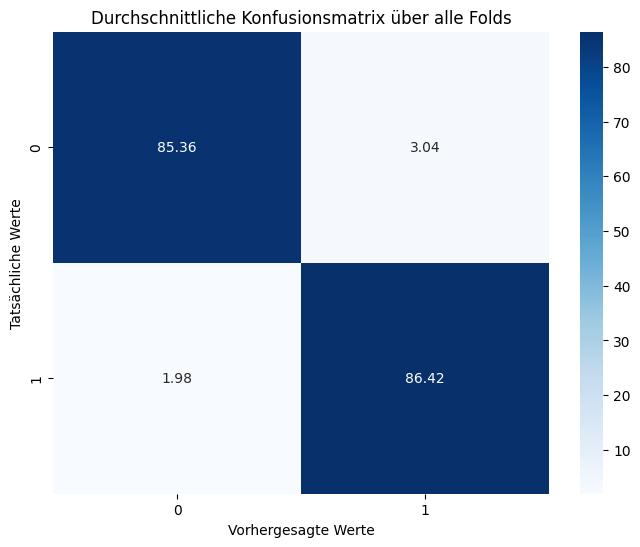

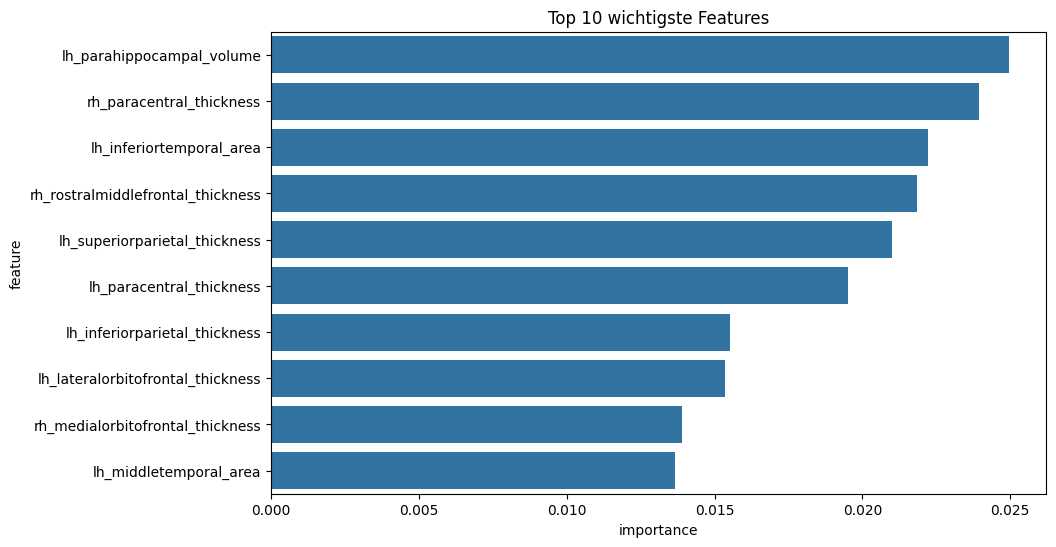

In [52]:

# Lade Flächen-Daten
df_pat_aparc_area = load_aparc_data('../dataset/freesurfer_thvosu_DKparcellation/aparc_area.txt')
df_cont_aparc_area = load_aparc_data('../dataset/freesurfer_thvosu_DKparcellation/controls_aparc_area.txt')

# Lade Volumen-Daten 
df_pat_aparc_volume = load_aparc_data('../dataset/freesurfer_thvosu_DKparcellation/aparc_vol.txt')
df_cont_aparc_volume = load_aparc_data('../dataset/freesurfer_thvosu_DKparcellation/controls_aparc_vol.txt')

# Lade Dicke-Daten
df_pat_aparc_thickness = load_aparc_data('../dataset/freesurfer_thvosu_DKparcellation/aparc_thick.txt')
df_cont_aparc_thickness = load_aparc_data('../dataset/freesurfer_thvosu_DKparcellation/controls_aparc_thick.txt')

# Lade sulcal-Daten
#df_pat_aseg_vol = load_aparc_data('../dataset/freesurfer_thvosu_DKparcellation/aseg_vol.txt')
#df_cont_aseg_vol = load_aparc_data('../dataset/freesurfer_thvosu_DKparcellation/controls_aseg_vol.txt')


# Ausgabe der ersten 5 Zeilen
# print(df_pat_aparc_volume.head())
#print(df_cont_aparc_area.head())
# Kombiniere alle Patienten-Daten basierend auf den ID-Spalten
df_patients = pd.merge(df_pat_aparc_area, df_pat_aparc_volume, 
                     left_on='lh.aparc.area', right_on='lh.aparc.volume')
df_patients = pd.merge(df_patients, df_pat_aparc_thickness,
                     left_on='lh.aparc.area', right_on='lh.aparc.thickness')

# Kombiniere alle Kontroll-Daten basierend auf den ID-Spalten
df_control = pd.merge(df_cont_aparc_area, df_cont_aparc_volume,
                    left_on='lh.aparc.area', right_on='lh.aparc.volume')
df_control = pd.merge(df_control, df_cont_aparc_thickness,
                    left_on='lh.aparc.area', right_on='lh.aparc.thickness')


# Überprüfe die Größe der Datensätze
print("Anzahl Patienten:", len(df_patients))
print("Anzahl Kontrollen:", len(df_control))

# Berechne das Verhältnis
ratio = len(df_patients) / len(df_control)
print(f"\nVerhältnis Patienten/Kontrollen: {ratio:.2f}")

# Verwende Random Over-Sampling für die Kontrollgruppe
from sklearn.utils import resample

# Over-sampling der Minderheitsklasse (Kontrollen)
df_control_upsampled = resample(df_control,
                               replace=True,
                               n_samples=len(df_patients),
                               random_state=None)

# Überprüfe die neuen Größen
print("\nNach Balancierung:")
print("Anzahl Patienten:", len(df_patients))
print("Anzahl Kontrollen:", len(df_control_upsampled))

# Ersetze das ursprüngliche df_control mit der balancierten Version
df_control = df_control_upsampled


# Füge die Diagnose-Spalte zu beiden DataFrames hinzu
df_patients['diagnosis'] = 'epilepsy'
df_control['diagnosis'] = 'healthy'

# Kombiniere die beiden DataFrames
df_combined = pd.concat([df_patients, df_control])


# Entferne die ID-Zeile und rh.aparc.area Spalte falls vorhanden
if 'ID' in df_combined.columns:
    df_combined = df_combined.drop('ID', axis=1)
if 'rh.aparc.area' in df_combined.columns:
    df_combined = df_combined.drop('rh.aparc.area', axis=1)
if 'lh.aparc.area' in df_combined.columns:
    df_combined = df_combined.drop('lh.aparc.area', axis=1)
if 'rh.aparc.volume' in df_combined.columns:
    df_combined = df_combined.drop('rh.aparc.volume', axis=1)
if 'lh.aparc.volume' in df_combined.columns:
    df_combined = df_combined.drop('lh.aparc.volume', axis=1)
if 'rh.aparc.thickness' in df_combined.columns:
    df_combined = df_combined.drop('rh.aparc.thickness', axis=1)
if 'lh.aparc.thickness' in df_combined.columns:
    df_combined = df_combined.drop('lh.aparc.thickness', axis=1)

    
# Trenne Features und Labels
X = df_combined.drop('diagnosis', axis=1)
y = df_combined['diagnosis']

print(X.columns)

# Gebe die Anzahl der Features aus
print(f"Anzahl der verwendeten Features: {X.shape[1]}")

# Importiere notwendige ML-Bibliotheken
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialisiere RepeatedStratifiedKFold
n_splits = 5
n_repeats = 10
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# Initialisiere Listen für die Metriken
y_true_all = []
y_pred_all = []

# Initialisiere Confusion Matrix
cm_total = np.zeros((2, 2))

# Durchführe repeated k-fold Cross-Validation
for fold, (train_index, test_index) in enumerate(rskf.split(X, y), 1):
    # Splitte Daten
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Standardisiere Features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Trainiere Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    
    # Mache Vorhersagen
    y_pred = rf_model.predict(X_test_scaled)
    
    # Sammle alle Vorhersagen und wahren Werte
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)
    
    # Aktualisiere Confusion Matrix
    cm_fold = confusion_matrix(y_test, y_pred)
    cm_total += cm_fold

# Zeige gemittelte Metriken am Ende
print("\nGemittelte Metriken über alle Folds:")
print(classification_report(y_true_all, y_pred_all))

# Zeige durchschnittliche Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_total/(n_splits*n_repeats), annot=True, fmt='.2f', cmap='Blues')
plt.title('Durchschnittliche Konfusionsmatrix über alle Folds')
plt.ylabel('Tatsächliche Werte')
plt.xlabel('Vorhergesagte Werte')
plt.show()

# Trainiere finales Modell auf allen Daten für Feature Importance
scaler_final = StandardScaler()
X_scaled_final = scaler_final.fit_transform(X)
rf_model_final = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_final.fit(X_scaled_final, y)

# Zeige Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model_final.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 wichtigste Features')
plt.show()






=== KNN ===

Klassifikationsbericht:
              precision    recall  f1-score   support

    epilepsy       0.99      0.91      0.95        88
     healthy       0.92      0.99      0.95        88

    accuracy                           0.95       176
   macro avg       0.95      0.95      0.95       176
weighted avg       0.95      0.95      0.95       176



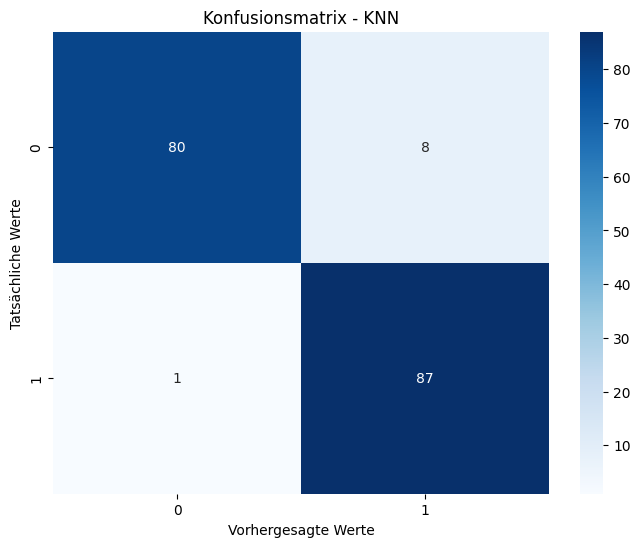


=== Gaussian NB ===

Klassifikationsbericht:
              precision    recall  f1-score   support

    epilepsy       0.67      0.58      0.62        88
     healthy       0.63      0.72      0.67        88

    accuracy                           0.65       176
   macro avg       0.65      0.65      0.65       176
weighted avg       0.65      0.65      0.65       176



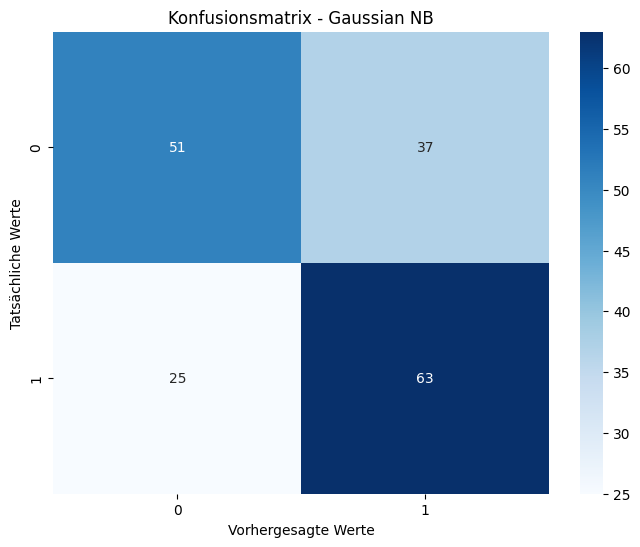


=== SVC ===

Klassifikationsbericht:
              precision    recall  f1-score   support

    epilepsy       0.91      0.90      0.90        88
     healthy       0.90      0.91      0.90        88

    accuracy                           0.90       176
   macro avg       0.90      0.90      0.90       176
weighted avg       0.90      0.90      0.90       176



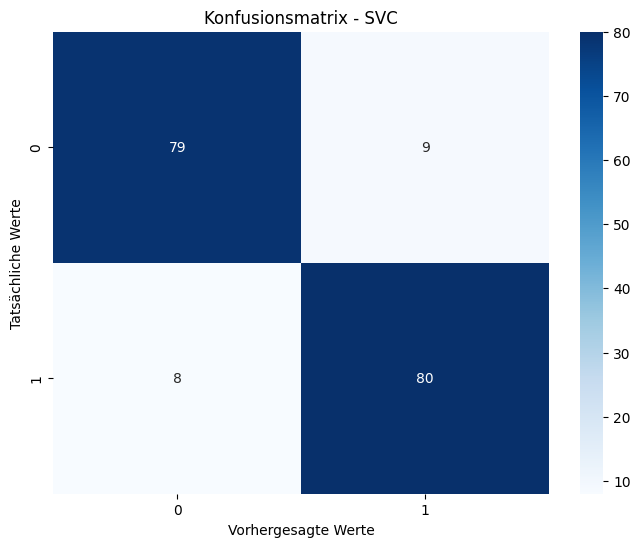


=== Logistische Regression ===

Klassifikationsbericht:
              precision    recall  f1-score   support

    epilepsy       0.99      0.84      0.91        88
     healthy       0.86      0.99      0.92        88

    accuracy                           0.91       176
   macro avg       0.92      0.91      0.91       176
weighted avg       0.92      0.91      0.91       176



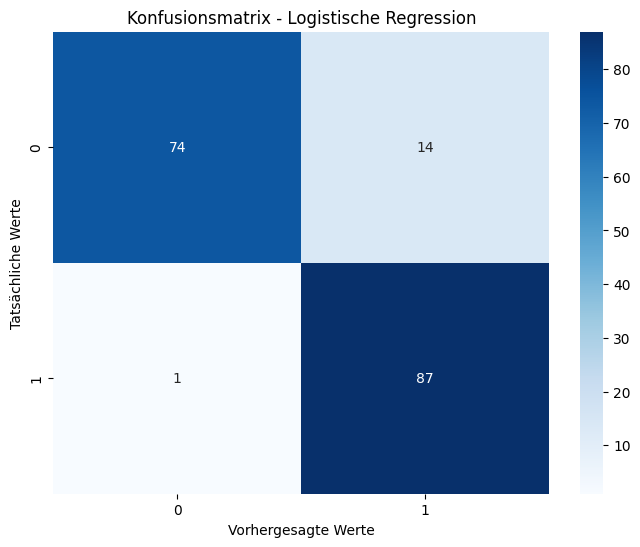

<Figure size 1200x600 with 0 Axes>

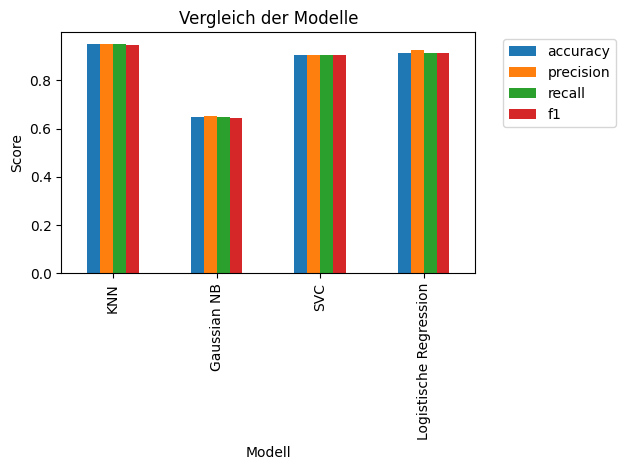

In [53]:
# Importiere zusätzliche Modelle und Metriken
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dictionary für alle Modelle
models = {
    'KNN': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
    'Gaussian NB': GaussianNB(),
    'SVC': SVC(kernel='rbf', random_state=42),
    'Logistische Regression': LogisticRegression(random_state=42)
}

# Ergebnisse speichern
results = {}

# Trainiere und evaluiere jedes Modell
for name, model in models.items():
    print(f"\n=== {name} ===")
    
    # Trainiere Modell
    model.fit(X_train_scaled, y_train)
    
    # Mache Vorhersagen
    y_pred = model.predict(X_test_scaled)
    
    # Speichere Metriken
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }
    
    # Zeige Klassifikationsbericht
    print("\nKlassifikationsbericht:")
    print(classification_report(y_test, y_pred))
    
    # Erstelle Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Konfusionsmatrix - {name}')
    plt.ylabel('Tatsächliche Werte')
    plt.xlabel('Vorhergesagte Werte')
    plt.show()

# Vergleiche alle Modelle
results_df = pd.DataFrame(results).T
plt.figure(figsize=(12, 6))
results_df.plot(kind='bar')
plt.title('Vergleich der Modelle')
plt.xlabel('Modell')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




Epoch 1/50


c:\Users\rickert\Documents\team_10\.venv2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5912 - loss: 0.6700 - val_accuracy: 0.4507 - val_loss: 0.8057
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7737 - loss: 0.4989 - val_accuracy: 0.6268 - val_loss: 0.6322
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8178 - loss: 0.3778 - val_accuracy: 0.7887 - val_loss: 0.4397
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9130 - loss: 0.2782 - val_accuracy: 0.7958 - val_loss: 0.4424
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8909 - loss: 0.2707 - val_accuracy: 0.8662 - val_loss: 0.3448
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9410 - loss: 0.2023 - val_accuracy: 0.8310 - val_loss: 0.3505
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9415 - loss: 0.1336 - val_accuracy: 0.8662 - val_loss: 0.1927
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9415 - loss: 0.1302 - val_accuracy: 0.8662 - val_loss: 0.2874
Ep

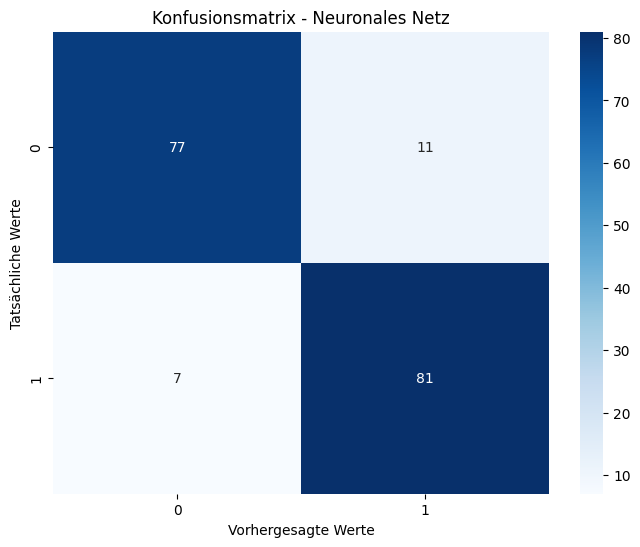

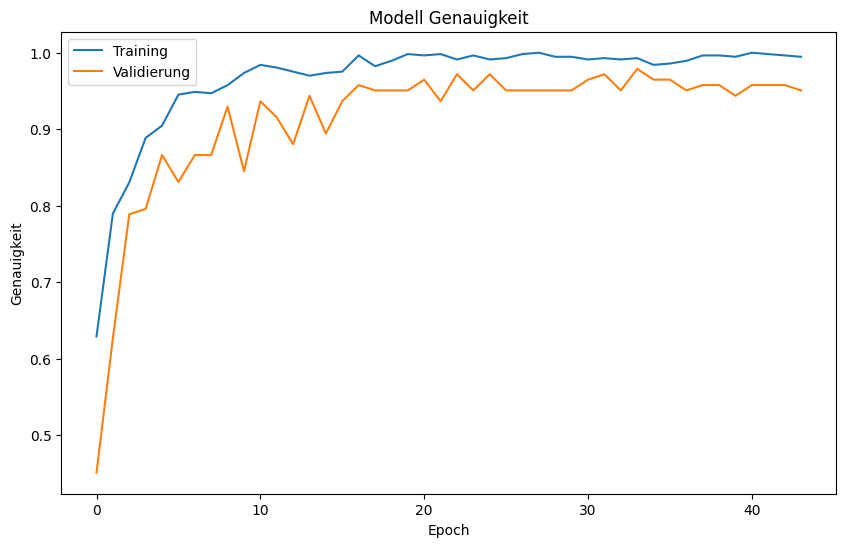

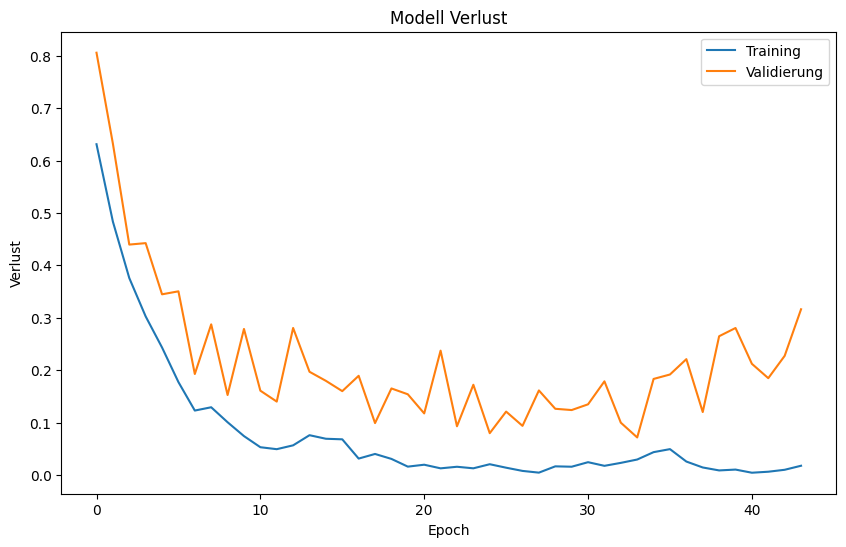

In [56]:
# Neuronales Netz mit Keras/TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping

# LabelEncoder für Zielwerte (y_train und y_test)
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_test_int = le.transform(y_test)

# One-Hot-Encoding für die Zielwerte
y_train_cat = to_categorical(y_train_int)
y_test_cat = to_categorical(y_test_int)

# Neuronales Netz erstellen
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(y_train_cat.shape[1], activation='sigmoid')
])

# Modell kompilieren
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early Stopping definieren, um Overfitting zu vermeiden
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10,  # Wie viele Epochen ohne Verbesserung erlaubt sind
                               restore_best_weights=True)

# Modell trainieren
history = model.fit(X_train_scaled, y_train_cat,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stopping])  # EarlyStopping einfügen

# Vorhersagen machen
y_pred_prob = model.predict(X_test_scaled)
y_pred_nn = le.inverse_transform(np.argmax(y_pred_prob, axis=1))

# Metriken berechnen
print("\n=== Neuronales Netz ===")
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred_nn))

# Konfusionsmatrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Konfusionsmatrix - Neuronales Netz')
plt.ylabel('Tatsächliche Werte')
plt.xlabel('Vorhergesagte Werte')
plt.show()

# Trainings- und Validierungsverlauf
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validierung')
plt.title('Modell Genauigkeit')
plt.xlabel('Epoch')
plt.ylabel('Genauigkeit')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validierung')
plt.title('Modell Verlust')
plt.xlabel('Epoch')
plt.ylabel('Verlust')
plt.legend()
plt.show()
